# USAD

## Environment

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn

from utils import *
from usad import *

In [2]:
device = get_default_device()

## EDA - Data Pre-Processing

### Normal period

In [3]:
#Read data
normal = pd.read_csv("input/SWaT_Dataset_Normal_v1.csv")#, nrows=1000)
normal = normal.drop(["Timestamp" , "Normal/Attack" ] , axis = 1)
normal.shape

/var/folders/k3/dm3pbfdd7ysgk9czg_x952pc0000gn/T/ipykernel_45872/3202893291.py:2: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  normal = pd.read_csv("input/SWaT_Dataset_Normal_v1.csv")#, nrows=1000)


(495000, 51)

In [4]:
# Transform all columns into float64
for i in list(normal): 
    normal[i]=normal[i].apply(lambda x: str(x).replace("," , "."))
normal = normal.astype(float)

#### Normalization

In [5]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()

x = normal.values
x_scaled = min_max_scaler.fit_transform(x)
normal = pd.DataFrame(x_scaled)

In [6]:
normal.head(2)

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
0,0.0,0.005294,0.5,0.0,0.0,0.012291,0.075099,0.002009,0.0,0.5,...,0.0,0.0,0.0,0.000814,0.0,0.001217,0.000147,0.0,0.0,0.0
1,0.0,0.005407,0.5,0.0,0.0,0.012291,0.075099,0.002009,0.0,0.5,...,0.0,0.0,0.0,0.000814,0.0,0.001217,0.000147,0.0,0.0,0.0


### Attack

In [7]:
#Read data
attack = pd.read_csv("input/SWaT_Dataset_Attack_v0.csv",sep=";")#, nrows=1000)
labels = [ float(label!= 'Normal' ) for label  in attack["Normal/Attack"].values]
attack = attack.drop(["Timestamp" , "Normal/Attack" ] , axis = 1)
attack.shape

/var/folders/k3/dm3pbfdd7ysgk9czg_x952pc0000gn/T/ipykernel_45872/12158840.py:2: DtypeWarning: Columns (1,9,28,46) have mixed types. Specify dtype option on import or set low_memory=False.
  attack = pd.read_csv("input/SWaT_Dataset_Attack_v0.csv",sep=";")#, nrows=1000)


(449919, 51)

In [8]:
# Transform all columns into float64
for i in list(attack):
    attack[i]=attack[i].apply(lambda x: str(x).replace("," , "."))
attack = attack.astype(float)

#### Normalization

In [9]:
from sklearn import preprocessing

x = attack.values 
x_scaled = min_max_scaler.transform(x)
attack = pd.DataFrame(x_scaled)

In [10]:
attack.head(2)

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
0,0.884144,0.577133,1.0,1.0,0.0,0.496158,0.188845,0.064088,0.982899,1.0,...,0.970903,1.0,0.0,0.946125,0.449782,0.944116,0.000073,0.0,0.0,0.0
1,0.891145,0.577190,1.0,1.0,0.0,0.496158,0.188845,0.064088,0.982899,1.0,...,0.970903,1.0,0.0,0.946125,0.449782,0.944521,0.000073,0.0,0.0,0.0


### Windows

In [11]:
window_size=12

In [12]:
windows_normal=normal.values[np.arange(window_size)[None, :] + np.arange(normal.shape[0]-window_size)[:, None]]
windows_normal.shape

(494988, 12, 51)

In [13]:
windows_attack=attack.values[np.arange(window_size)[None, :] + np.arange(attack.shape[0]-window_size)[:, None]]
windows_attack.shape

(449907, 12, 51)

## Training

In [14]:
import torch.utils.data as data_utils

BATCH_SIZE = 5000
N_EPOCHS = 10
hidden_size = 100

w_size=windows_normal.shape[1]*windows_normal.shape[2]
z_size=windows_normal.shape[1]*hidden_size

windows_normal_train = windows_normal[:int(np.floor(.8 *  windows_normal.shape[0]))]
windows_normal_val = windows_normal[int(np.floor(.8 *  windows_normal.shape[0])):int(np.floor(windows_normal.shape[0]))]

train_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
    torch.from_numpy(windows_normal_train).float().view(([windows_normal_train.shape[0],w_size]))
) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

val_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
    torch.from_numpy(windows_normal_val).float().view(([windows_normal_val.shape[0],w_size]))
) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

test_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
    torch.from_numpy(windows_attack).float().view(([windows_attack.shape[0],w_size]))
) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

model = UsadModel(w_size, z_size)
model = to_device(model,device)

In [15]:
history = training(N_EPOCHS,model,train_loader,val_loader)

Epoch[0], val_loss1: 0.0182, val_loss2: 0.0174
Epoch[1], val_loss1: 0.0476, val_loss2: -0.0313
Epoch[2], val_loss1: 0.0603, val_loss2: -0.0495
Epoch[3], val_loss1: 0.0155, val_loss2: -0.0074
Epoch[4], val_loss1: 0.0139, val_loss2: -0.0085
Epoch[5], val_loss1: 0.0143, val_loss2: -0.0097
Epoch[6], val_loss1: 0.0139, val_loss2: -0.0099
Epoch[7], val_loss1: 0.0146, val_loss2: -0.0112
Epoch[8], val_loss1: 0.1189, val_loss2: -0.1141
Epoch[9], val_loss1: 0.0615, val_loss2: -0.0531


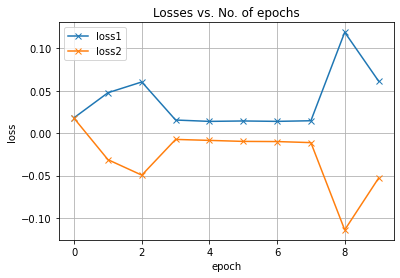

In [16]:
plot_history(history)

In [17]:
torch.save({
            'encoder': model.encoder.state_dict(),
            'decoder1': model.decoder1.state_dict(),
            'decoder2': model.decoder2.state_dict()
            }, "model.pth")

## Testing

In [18]:
checkpoint = torch.load("model.pth")

model.encoder.load_state_dict(checkpoint['encoder'])
model.decoder1.load_state_dict(checkpoint['decoder1'])
model.decoder2.load_state_dict(checkpoint['decoder2'])

<All keys matched successfully>

In [19]:
results=testing(model,test_loader)

In [20]:
windows_labels=[]
for i in range(len(labels)-window_size):
    windows_labels.append(list(np.int_(labels[i:i+window_size])))

In [21]:
y_test = [1.0 if (np.sum(window) > 0) else 0 for window in windows_labels ]

In [22]:
counts = 0
for y in y_test:
    if y:
        counts += 1
counts

55006

In [23]:
print("Total samples: ", len(y_test))
print("Percentage of Anomalies:", counts/len(y_test))

Total samples:  449907
Percentage of Anomalies: 0.12226082279226595


In [24]:
y_pred=np.concatenate([torch.stack(results[:-1]).flatten().detach().cpu().numpy(),
                              results[-1].flatten().detach().cpu().numpy()])

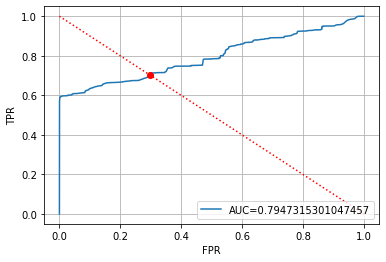

In [25]:
threshold=ROC(y_test,y_pred)

## Comparison with Basic AutoEncoder

In [26]:
from ae import *
ae_model = AE(w_size, z_size)
ae_model = to_device(ae_model,device)

In [27]:
history_ae = training_ae(N_EPOCHS,ae_model,train_loader,val_loader)

Epoch[0], val_loss:0.0007
Epoch[1], val_loss:0.0001
Epoch[2], val_loss:0.0000
Epoch[3], val_loss:0.0000
Epoch[4], val_loss:0.0000
Epoch[5], val_loss:0.0000
Epoch[6], val_loss:0.0000
Epoch[7], val_loss:0.0000
Epoch[8], val_loss:0.0000
Epoch[9], val_loss:0.0000


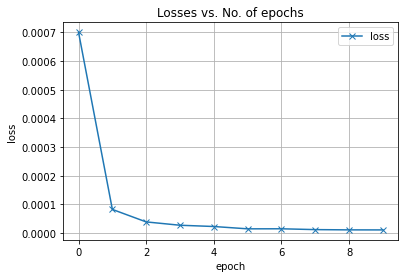

In [28]:
losses = [x['val_loss'] for x in history_ae]
plt.plot(losses, '-x', label="loss")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.title('Losses vs. No. of epochs')
plt.grid()
plt.show()

In [29]:
torch.save({
            'encoder': ae_model.encoder.state_dict(),
            'decoder': ae_model.decoder.state_dict()
            }, "ae.pth")

In [30]:
results_ae=testing_ae(ae_model,test_loader)
pred_ae=np.concatenate([torch.stack(results_ae[:-1]).flatten().detach().cpu().numpy(),
                              results_ae[-1].flatten().detach().cpu().numpy()])

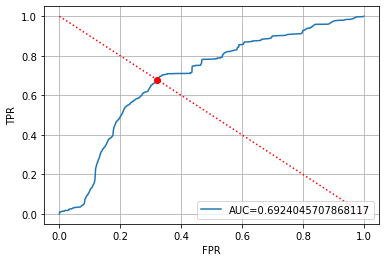

In [31]:
threshold_ae=ROC(y_test,pred_ae)

## Parameter Tuning

#### Increase number of epochs

In [32]:
def define_model(BATCH_SIZE, N_EPOCHS, hidden_size):

    w_size=windows_normal.shape[1]*windows_normal.shape[2]
    z_size=windows_normal.shape[1]*hidden_size

    windows_normal_train = windows_normal[:int(np.floor(.8 *  windows_normal.shape[0]))]
    windows_normal_val = windows_normal[int(np.floor(.8 *  windows_normal.shape[0])):int(np.floor(windows_normal.shape[0]))]

    train_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
        torch.from_numpy(windows_normal_train).float().view(([windows_normal_train.shape[0],w_size]))
    ) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

    val_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
        torch.from_numpy(windows_normal_val).float().view(([windows_normal_val.shape[0],w_size]))
    ) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

    test_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
        torch.from_numpy(windows_attack).float().view(([windows_attack.shape[0],w_size]))
    ) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

    model = UsadModel(w_size, z_size)
    model = to_device(model,device)
    return model, train_loader, val_loader, test_loader

In [33]:
model1, train_loader1, val_loader1, test_loader1 = define_model(7919, 50, 100)

In [34]:
history1 = training(50,model1,train_loader1,val_loader1)

Epoch[0], val_loss1: 0.0251, val_loss2: 0.0253
Epoch[1], val_loss1: 0.0145, val_loss2: -0.0003
Epoch[2], val_loss1: 0.0185, val_loss2: -0.0068
Epoch[3], val_loss1: 0.0181, val_loss2: -0.0095
Epoch[4], val_loss1: 0.0145, val_loss2: -0.0089
Epoch[5], val_loss1: 0.0151, val_loss2: -0.0105
Epoch[6], val_loss1: 0.0150, val_loss2: -0.0113
Epoch[7], val_loss1: 0.0142, val_loss2: -0.0110
Epoch[8], val_loss1: 0.0157, val_loss2: -0.0129
Epoch[9], val_loss1: 0.0202, val_loss2: -0.0171
Epoch[10], val_loss1: 0.0182, val_loss2: -0.0157
Epoch[11], val_loss1: 0.0192, val_loss2: -0.0167
Epoch[12], val_loss1: 0.0218, val_loss2: -0.0198
Epoch[13], val_loss1: 0.0202, val_loss2: -0.0182
Epoch[14], val_loss1: 0.0201, val_loss2: -0.0184
Epoch[15], val_loss1: 0.1246, val_loss2: -0.1200
Epoch[16], val_loss1: 0.1304, val_loss2: -0.1279
Epoch[17], val_loss1: 0.1357, val_loss2: -0.1270
Epoch[18], val_loss1: 0.2272, val_loss2: -0.2119
Epoch[19], val_loss1: 0.2258, val_loss2: -0.2130
Epoch[20], val_loss1: 0.2267, v

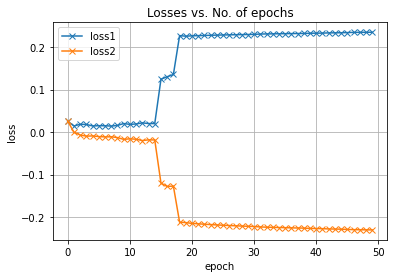

In [35]:
plot_history(history1)

In [36]:
torch.save({
            'encoder': model1.encoder.state_dict(),
            'decoder1': model1.decoder1.state_dict(),
            'decoder2': model1.decoder2.state_dict()
            }, "model1.pth")

In [37]:
checkpoint1 = torch.load("model1.pth")

model1.encoder.load_state_dict(checkpoint1['encoder'])
model1.decoder1.load_state_dict(checkpoint1['decoder1'])
model1.decoder2.load_state_dict(checkpoint1['decoder2'])

<All keys matched successfully>

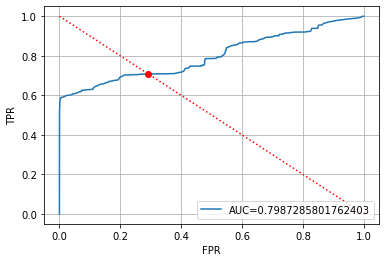

In [38]:
results1=testing(model1,test_loader1)
y_pred1=np.concatenate([torch.stack(results1[:-1]).flatten().detach().cpu().numpy(),
                              results1[-1].flatten().detach().cpu().numpy()])
threshold1=ROC(y_test,y_pred1)

In [39]:
threshold1

array([0.40142596], dtype=float32)

#### Batch Size

In [40]:
model2, train_loader2, val_loader2, test_loader2 = define_model(7919, 10, 100)

In [41]:
history2 = training(10,model2,train_loader2,val_loader2)

Epoch[0], val_loss1: 0.0259, val_loss2: 0.0262
Epoch[1], val_loss1: 0.0292, val_loss2: -0.0060
Epoch[2], val_loss1: 0.0353, val_loss2: -0.0237
Epoch[3], val_loss1: 0.1150, val_loss2: -0.0871
Epoch[4], val_loss1: 0.1101, val_loss2: -0.0981
Epoch[5], val_loss1: 0.1140, val_loss2: -0.0865
Epoch[6], val_loss1: 0.1162, val_loss2: -0.1081
Epoch[7], val_loss1: 0.1156, val_loss2: -0.1102
Epoch[8], val_loss1: 0.0396, val_loss2: -0.0346
Epoch[9], val_loss1: 0.0367, val_loss2: -0.0309


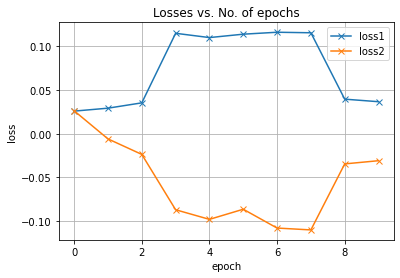

In [42]:
plot_history(history2)

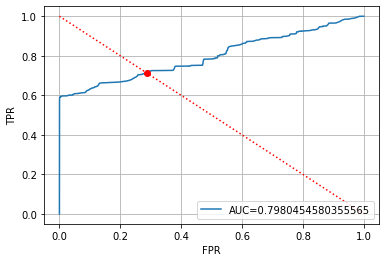

In [43]:
torch.save({
            'encoder': model2.encoder.state_dict(),
            'decoder1': model2.decoder1.state_dict(),
            'decoder2': model2.decoder2.state_dict()
            }, "model2.pth")

checkpoint2 = torch.load("model2.pth")

model2.encoder.load_state_dict(checkpoint2['encoder'])
model2.decoder1.load_state_dict(checkpoint2['decoder1'])
model2.decoder2.load_state_dict(checkpoint2['decoder2'])

results2=testing(model2,test_loader2)
y_pred2=np.concatenate([torch.stack(results2[:-1]).flatten().detach().cpu().numpy(),
                              results2[-1].flatten().detach().cpu().numpy()])
threshold2=ROC(y_test,y_pred2)

#### Hidden Nodes

In [44]:
# model3, train_loader3, val_loader3, test_loader3 = define_model(7919, 10, 150)

In [45]:
# history3 = training(5,model3,train_loader3,val_loader3)

In [46]:
# plot_history(history3)

In [47]:
# torch.save({
#             'encoder': model3.encoder.state_dict(),
#             'decoder1': model3.decoder1.state_dict(),
#             'decoder2': model3.decoder2.state_dict()
#             }, "model3.pth")

# checkpoint3 = torch.load("model3.pth")

# model3.encoder.load_state_dict(checkpoint3['encoder'])
# model3.decoder1.load_state_dict(checkpoint3['decoder1'])
# model3.decoder2.load_state_dict(checkpoint3['decoder2'])

# results3=testing(model3,test_loader3)
# y_pred3=np.concatenate([torch.stack(results3[:-1]).flatten().detach().cpu().numpy(),
#                               results3[-1].flatten().detach().cpu().numpy()])
# threshold3=ROC(y_test,y_pred3)

#### Optimal Model

In [48]:
optimal_model, optimal_train_loader, optimal_val_loader, optimal_test_loader = define_model(7919, 100, 100)
history_optimal = training(100,optimal_model,optimal_train_loader,optimal_val_loader)

Epoch[0], val_loss1: 0.0254, val_loss2: 0.0254
Epoch[1], val_loss1: 0.0152, val_loss2: -0.0003
Epoch[2], val_loss1: 0.0314, val_loss2: -0.0197
Epoch[3], val_loss1: 0.0150, val_loss2: -0.0079
Epoch[4], val_loss1: 0.0390, val_loss2: -0.0254
Epoch[5], val_loss1: 0.0274, val_loss2: -0.0202
Epoch[6], val_loss1: 0.0275, val_loss2: -0.0214
Epoch[7], val_loss1: 0.0289, val_loss2: -0.0231
Epoch[8], val_loss1: 0.0298, val_loss2: -0.0248
Epoch[9], val_loss1: 0.0320, val_loss2: -0.0274
Epoch[10], val_loss1: 0.0302, val_loss2: -0.0261
Epoch[11], val_loss1: 0.0331, val_loss2: -0.0291
Epoch[12], val_loss1: 0.0318, val_loss2: -0.0282
Epoch[13], val_loss1: 0.0343, val_loss2: -0.0308
Epoch[14], val_loss1: 0.0339, val_loss2: -0.0306
Epoch[15], val_loss1: 0.0343, val_loss2: -0.0313
Epoch[16], val_loss1: 0.0338, val_loss2: -0.0309
Epoch[17], val_loss1: 0.0350, val_loss2: -0.0323
Epoch[18], val_loss1: 0.0368, val_loss2: -0.0341
Epoch[19], val_loss1: 0.0346, val_loss2: -0.0320
Epoch[20], val_loss1: 0.0338, v

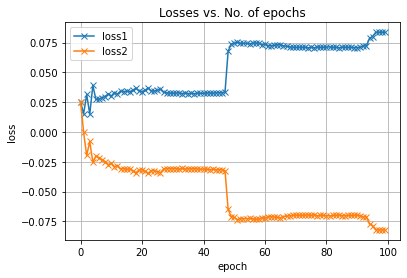

In [49]:
plot_history(history_optimal)

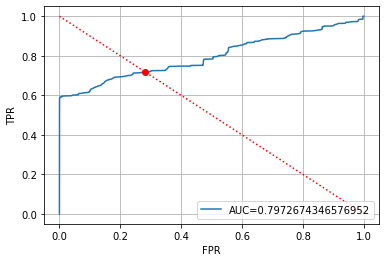

In [50]:
torch.save({
            'encoder': optimal_model.encoder.state_dict(),
            'decoder1': optimal_model.decoder1.state_dict(),
            'decoder2': optimal_model.decoder2.state_dict()
            }, "optimal.pth")

optimal_checkpoint = torch.load("optimal.pth")

optimal_model.encoder.load_state_dict(optimal_checkpoint['encoder'])
optimal_model.decoder1.load_state_dict(optimal_checkpoint['decoder1'])
optimal_model.decoder2.load_state_dict(optimal_checkpoint['decoder2'])

optimal_results=testing(optimal_model,optimal_test_loader)
optimal_y_pred=np.concatenate([torch.stack(optimal_results[:-1]).flatten().detach().cpu().numpy(),
                              optimal_results[-1].flatten().detach().cpu().numpy()])
optimal_threshold=ROC(y_test,optimal_y_pred)